In [5]:
import pandas as pd
visits=pd.read_csv('visits_log.csv')
orders=pd.read_csv('orders_log.csv')
costs=pd.read_csv('costs.csv')

import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
#pd.set_option('display.max_columns', None)
pd.options.mode.chained_assignment = None
pd.options.display.max_colwidth = 100
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500) 
pd.set_option('display.width', 1000)
import math
import numpy as np
import seaborn as sns
from scipy import stats as st

# Оптимизация маркетинговых затрат Яндекс.Афиши

### Задача: изучить, как люди пользуются продуктом, когда они начинают покупать, сколько денег приносит каждый клиент и когда он окупается.

1. [**Подготовка данных к анализу.**](#100101)
**************
2. [**Отчеты и метрики.**](#100102)
    * [2.1.Сколько длится одна сессия?](#102100)
    * [2.2.Сколько людей пользуются Яндекс.Афишей в день, неделю, месяц? В каких рекламных источниках есть нулевые сессии.](#102101)
    * [2.3.Как часто люди возвращаются?](#102102)
    * [2.4.Сравнение количества пользователей настольных и мобильных ПК.](#102103)
    * [2.5.Доходы от пользователей разных типов ПК.](#102104)
*******************
3. [**Разделим данные по устройствам.**](#100103)
    * [3.1.Расходы разных рекламных источников для пользователей мобильных ПК по месяцам.](#103100)
    * [3.2.Посмотрим общее количество сессий по месяцам на мобильных ПК.](#103101)
    * [3.3.Расходы разных рекламных источников для пользователей настольных ПК по месяцам.](#103102)
    * [3.4.Посмотрим общее количество сессий по месяцам на настольных ПК.](#103103)
**************
4. [**Проверка гипотез**](#100104)
    * [4.1.Одинаковое ли время проводят пользователи двух видов устройств в Яндекс.Афише?](#104100)
    * [4.2.Зависит ли процент отказов от вида устройства?](#104101)
*******************
5. [**Исследование заказов.**](#100105)
    * [5.1.Сколько людей совершают покупки впервые и продолжают покупать в следующих месяцах после совершения первой покупки.](#105100)
    * [5.2.Активность пользователей по месяцам.](#105101)
    * [5.3.Соотношение количества покупок и прибыли к пользователям по месяцам.](#105102)
    * [5.4.Насколько активно разные когорты покупают? Насколько дорогостоящие покупки?](#105103)
    * [5.5.Как изменяется количество покупающих внутри одной когорты?](#105104)
    * [5.6.Относительные показатели по времени жизни.](#105105)
    * [5.7.Экономика одной продажи.LTV.](#105106)
***************
6. [**Маркетинг.**](#100106)
    * [6.1.Сколько всего денег потратили на привлечение?](#106100)
    * [6.2.Расходы в месяц на рекламу.](#106101)
    * [6.3.Сколько денег потрачено на каждый источник?](#106102)
    * [6.4.Расходы в месяц на рекламу по каждому рекламному источнику.](#106103)
    * [6.5.Коррелируют ли расходы на рекламу с получением прибыли?](#106104)
    * [6.6.САС (стоимость привлечения одного клиента) и ROMI для каждого источника.](#106105)
    * [6.7.Когда окупается клиент?](#106106)
    * [6.8.Как быстро окупаются когорты?](#106107)
*****************
7. [**Выводы.**](#100107)
8. [**Рекомендации.**](#100108)

### 1. Подготовка данных к анализу. <a id='100101'></a>

> лог сервера с данными о посещениях сайта Яндекс.Афиши с июня 2017 по конец мая 2018 года

In [6]:
visits.info()
visits.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 358532 entries, 0 to 358531
Data columns (total 5 columns):
Uid          358532 non-null uint64
Device       358532 non-null object
End Ts       358532 non-null object
Source Id    358532 non-null int64
Start Ts     358532 non-null object
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


,Uid,Device,End Ts,Source Id,Start Ts
0,16879256277535980062,touch,20.12.2017 17:38,4,20.12.2017 17:20
1,104060357244891740,desktop,19.02.2018 17:21,2,19.02.2018 16:53
2,7459035603376831527,touch,01.07.2017 1:54,5,01.07.2017 1:54
3,16174680259334210214,desktop,20.05.2018 11:23,9,20.05.2018 10:59
4,9969694820036681168,desktop,27.12.2017 14:06,3,27.12.2017 14:06


In [7]:
visits.isnull().sum()

Uid          0
Device       0
End Ts       0
Source Id    0
Start Ts     0
dtype: int64

Пустых ячеек нет.
* *переименуем колонки для удобства,*
* *изменим тип данных колонок со временем на datetime.*

In [8]:
visits.columns = ['uid', 'device', 'end_ts', 'source_id', 'start_ts']
visits['end_ts'] = pd.to_datetime(visits['end_ts'], format='%d.%m.%Y %H:%M')
visits['start_ts'] = pd.to_datetime(visits['start_ts'], format='%d.%m.%Y %H:%M')
#visits.info()               проверим
#visits.describe()

#посмотрим промежуток дат для начала визита:
visits['start_ts'].describe()

count                  358532
unique                 223977
top       2017-11-24 16:06:00
freq                       19
first     2017-06-01 00:01:00
last      2018-05-31 23:59:00
Name: start_ts, dtype: object

In [9]:
#посмотрим промежуток дат для конца визита:
visits['end_ts'].describe()

count                  358532
unique                 223894
top       2017-11-24 16:51:00
freq                       23
first     2017-06-01 00:02:00
last      2018-06-01 01:26:00
Name: end_ts, dtype: object

Список дат оказался неодинаков, это явно ошибка, 
* *сделаем срез не включающий 1 июня 2018 года.*

In [10]:
visits = visits[visits['end_ts'] < '2018-06-01 00:00:00']
#проверим visits['end_ts'].describe()

In [11]:
#проверим количество и название категорий устройства
visits['device'].unique()
#visits['device'].describe()

array(['touch', 'desktop'], dtype=object)

> заказы за период с июня 2017 по конец мая 2018 года

In [12]:
orders.info()
orders.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
Buy Ts     50415 non-null object
Revenue    50415 non-null float64
Uid        50415 non-null uint64
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


,Buy Ts,Revenue,Uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450


In [13]:
orders.isnull().sum()

Buy Ts     0
Revenue    0
Uid        0
dtype: int64

Пустых ячеек нет.
* *переименуем колонки для удобства,*
* *изменим тип данные колонки со временем на datetime.*

In [14]:
orders.columns = ['buy_ts', 'revenue', 'uid']
orders['buy_ts'] = pd.to_datetime(orders['buy_ts'], format='%Y-%m-%d %H:%M:%S')
#orders.info()        проверим

In [15]:
#посмотрим промежуток дат для заказов:
orders['buy_ts'].describe()

count                   50415
unique                  45991
top       2018-05-31 10:13:00
freq                        9
first     2017-06-01 00:10:00
last      2018-06-01 00:02:00
Name: buy_ts, dtype: object

*Сделаем срез не включающий 1 июня 2018 года, как и в таблице visits.*

In [16]:
orders = orders[orders['buy_ts'] < '2018-06-01 00:00:00']

> статистика рекламных расходов с июня 2017 по конец мая 2018 года

In [17]:
costs.info()
costs.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null object
costs        2542 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08


In [18]:
costs.isnull().sum()

source_id    0
dt           0
costs        0
dtype: int64

Пустых ячеек нет.

* *изменим тип данных колонки со временем на datetime*

In [19]:
costs['dt'] = pd.to_datetime(costs['dt'], format='%Y-%m-%d')
#costs.info()   проверим

In [20]:
#посмотрим промежуток дат рекламы:
costs['dt'].describe()

count                    2542
unique                    364
top       2018-03-03 00:00:00
freq                        7
first     2017-06-01 00:00:00
last      2018-05-31 00:00:00
Name: dt, dtype: object

### 2. Построим отчеты и посчитаем метрики: <a id='100102'></a>

### 2.1. Сколько длится одна сессия? <a id='102100'></a>

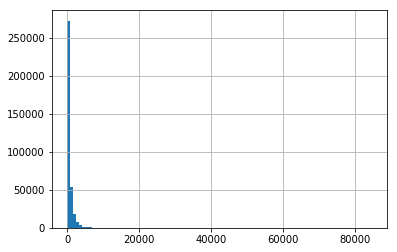

In [21]:
visits['session_duration_sec'] = (visits['end_ts'] - visits['start_ts']).dt.seconds
asl = visits['session_duration_sec'].mode()
visits['session_duration_sec'].hist(bins=100)
#сколько длится одна сессия

In [22]:
print('Сессия длится, в среднем, в секундах:', asl)

Сессия длится, в среднем, в секундах: 0    60
dtype: int64


In [23]:
visits['session_duration_sec'].describe()

count    358520.000000
mean        644.977574
std        1017.045330
min           0.000000
25%         120.000000
50%         300.000000
75%         840.000000
max       84480.000000
Name: session_duration_sec, dtype: float64

Из данных видно что есть сессии и по 5 и даже 23 часа. **ОБРАТИТЬ ВНИМАНИЕ!**

In [24]:
#visits.query('session_duration_sec > 18000')

### 2.2. Сколько людей пользуются Яндекс.Афишей в день, неделю, месяц? В каких рекламных источниках есть нулевые сессии. <a id='102101'></a>

In [25]:
#количество посетителей за год:
visits['uid'].value_counts().sum()

358520

In [26]:
#количество посетителей из разных рекламных источников:
visits['source_id'].value_counts()

4     101649
3      85447
5      66709
2      47471
1      33941
9      13257
10     10004
7         36
6          6
Name: source_id, dtype: int64

Более всего посетителей с 3 и 4 рекламных источников.

In [27]:
#выясним в каких рекламных источниках присутствуют нулевые сессии:

v2 = visits.query('session_duration_sec == 0')
print('Количество отказов:', v2['session_duration_sec'].count())
null_session = v2.pivot_table(index='source_id', values='session_duration_sec', aggfunc='count').reset_index()
null_session

Количество отказов: 35794


,source_id,session_duration_sec
0,1,1975
1,2,4158
2,3,9025
3,4,10898
4,5,7385
5,6,1
6,7,1
7,9,1297
8,10,1054


(0, 11000)

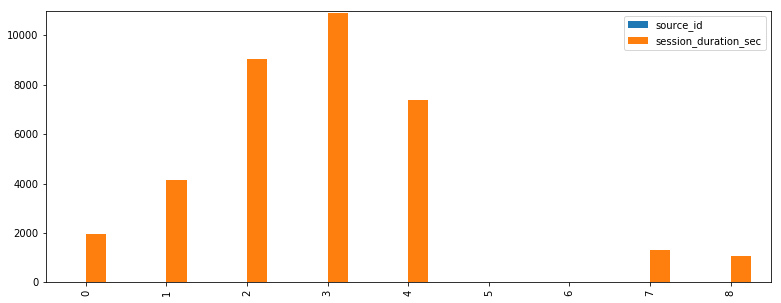

In [28]:
null_session.plot(kind='bar', figsize=(13, 5))
plt.ylim(0, 11000)

Процент отказов довольно высок, необходимо проверить 3 (10,5%), 4 (10,7%) и 5 (11%) источники, на предмет проблем в технической части обеспечения рекламной кампании.

In [29]:
#время использования в день, неделю, месяц:
visits['session_year']  = visits['start_ts'].dt.year
visits['session_month'] = visits['start_ts'].dt.month
visits['session_week']  = visits['start_ts'].dt.week
visits['session_date'] = visits['start_ts'].dt.date

#сгруппируем по пользователям и найдем среднее:
dau_total = visits.groupby('session_date').agg({'uid': 'nunique'}).mean()
wau_total = visits.groupby(['session_year', 'session_week']).agg({'uid': 'nunique'}).mean()
mau_total = visits.groupby(['session_year', 'session_month']).agg({'uid': 'nunique'}).mean()
print('DAU (количество уникальных пользователей в день) -', int(dau_total))
print('WAU (количество уникальных пользователей в неделю) -', int(wau_total))
print('MAU (количество уникальных пользователей в месяц) -', int(mau_total))

DAU (количество уникальных пользователей в день) - 907
WAU (количество уникальных пользователей в неделю) - 5716
MAU (количество уникальных пользователей в месяц) - 23227


### 2.3. Как часто люди возвращаются? <a id='102102'></a>

In [30]:
#как часто люди возвращаются:
sticky_mau = dau_total / mau_total * 100
sticky_wau = dau_total / wau_total * 100
print('Регулярность использования по отношению к месячной аудитории:', sticky_mau.round(2))
print('Регулярность использования по отношению к недельной аудитории:', sticky_wau.round(2))

Регулярность использования по отношению к месячной аудитории: uid    3.91
dtype: float64
Регулярность использования по отношению к недельной аудитории: uid    15.88
dtype: float64


In [31]:
orders['buy_ts'].describe()

count                   50414
unique                  45990
top       2018-05-31 10:13:00
freq                        9
first     2017-06-01 00:10:00
last      2018-05-31 23:56:00
Name: buy_ts, dtype: object

### 2.4. Сравнение количества пользователей настольных и мобильных ПК. <a id='102103'></a>

In [32]:
visits['session_date'] = visits['session_date'].astype('datetime64[M]')
touch = visits.query('device == "touch"')
print('Количество пользователей мобильных ПК:', touch['uid'].value_counts().sum())
dtop = visits.query('device == "desktop"')
print('Количество пользователей настольных ПК:', dtop['uid'].value_counts().sum())

Количество пользователей мобильных ПК: 96615
Количество пользователей настольных ПК: 261905


Количество пользователей настольных компьютеров в 2.7 раза больше чем мобильных.

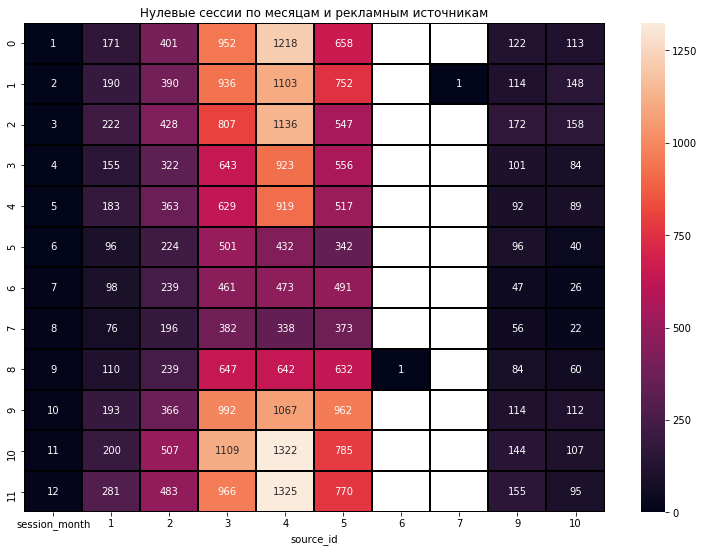

In [33]:
#вернемся к нулевым сессиям, посмотрим количество нулевых сессий по месяцам и источникам:
v3 = visits.query('session_duration_sec == 0')
null_session_month = v3.pivot_table(index='session_month', columns='source_id', values='session_duration_sec', aggfunc='count').reset_index()
plt.figure(figsize=(13, 9)) 
plt.title('Нулевые сессии по месяцам и рекламным источникам') 
sns.heatmap(null_session_month, fmt='.0f', annot=True, linewidths=1, linecolor='black')

Пик нулевых сессий приходится на пик заходов по рекламе, что вполне естественно, но 10% отказов, возможно потребует дальнейшего анализа.

### 2.5. Доходы от пользователей разных типов ПК. <a id='102104'></a>

(0, 1000000)

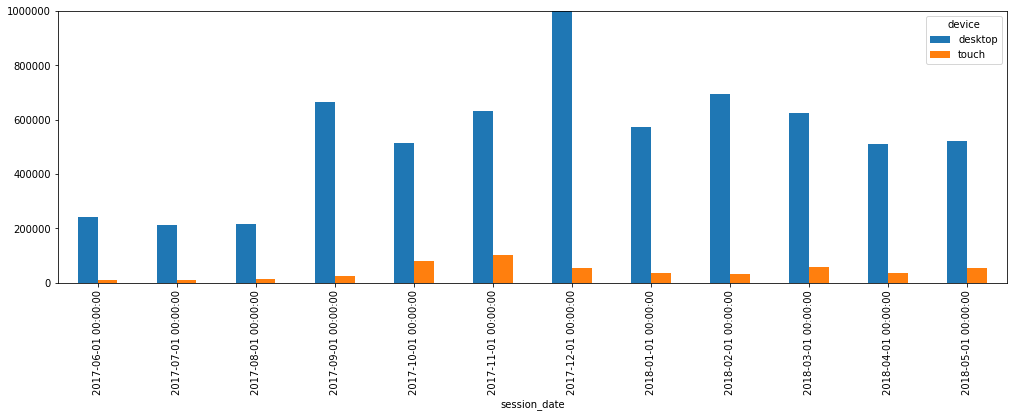

In [34]:
source_rev = pd.merge(orders, visits, on='uid')
source_rev = source_rev.pivot_table(index='session_date', columns = 'device', values='revenue', aggfunc='sum')
source_rev.plot(kind='bar', figsize=(17, 5))
plt.ylim(0, 1000000)

С большим отрывом лидируют стационарные компьютеры, пик доходов от них приходится на декабрь, минимальный доход в июле-августе. У мобильных ПК максимум в ноябре.

### 3. Разделим данные по устройствам. <a id='100103'></a>

### 3.1. Расходы разных рекламных источников для пользователей мобильных ПК по месяцам. <a id='103100'></a>

(0, 4200)

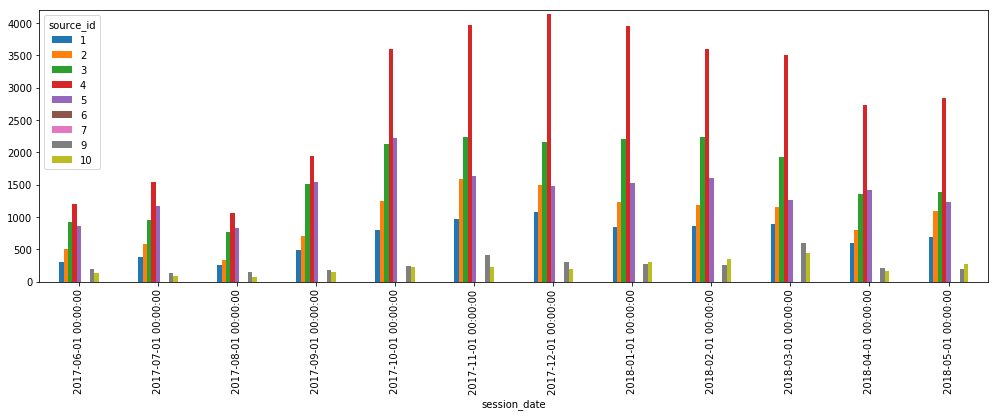

In [35]:
tt = touch.pivot_table(index='session_date', columns='source_id', values='uid', aggfunc='count')
tt.plot(kind='bar', figsize=(17, 5))
plt.ylim(0, 4200)

Расходы на 4 источник самые большие, так же растут и расходы на все источники начиная с октября 2017. Источники 6 и 7 практически не представлены, похоже на аномалии. **ОБРАТИТЬ ВНИМАНИЕ!** Минимальные расходы на источники 9 и 10.

### 3.2. Посмотрим общее количество сессий по месяцам на мобильных ПК. <a id='103101'></a>

(0, 6300000)

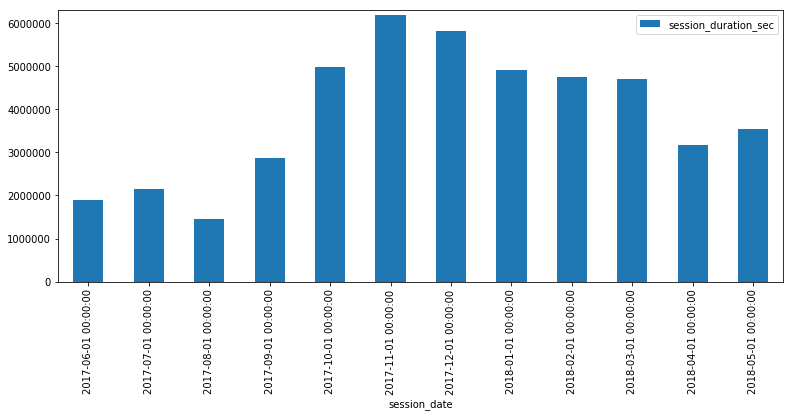

In [36]:
#пересчитаем секунды в минуты, заодно будет видно количество сессий в сумме на мобильных ПК по месяцам:
visits['session_duration_sec'] = visits['session_duration_sec'] / 60
s_dur_min_touch = touch.pivot_table(index='session_date', values='session_duration_sec', aggfunc='sum')
s_dur_min_touch.plot(kind='bar', figsize=(13, 5))
plt.ylim(0, 6300000)

Резкий рост использования наблюдается с октября 2017 по март 2018 включительно, пик приходится на ноябрь - примерно 105000 часов. Нужно изучить влияние погоды/времени года и новых премьер.

### 3.3. Расходы разных рекламных источников для пользователей настольных ПК по месяцам. <a id='103102'></a>

(0, 9400)

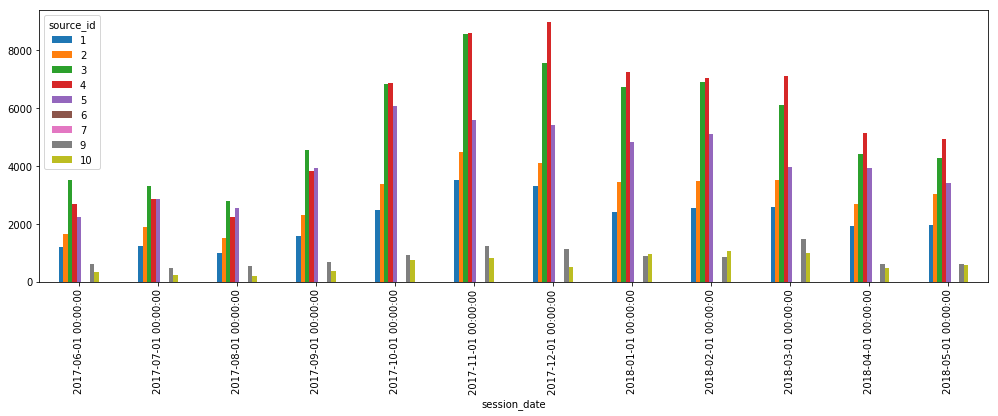

In [37]:
dd = dtop.pivot_table(index='session_date', columns='source_id', values='uid', aggfunc='count')
dd.plot(kind='bar', figsize=(17, 5))
plt.ylim(0, 9400)

Расходы в данной категории на 3 и 4 источник самые большие и близки друг к другу, так же растут и расходы на все источники начиная с октября 2017, следовательно это общая тенденция. Источники 6 и 7 практически не представлены, похоже на аномалии. **ОБРАТИТЬ ВНИМАНИЕ!** Минимальные расходы на источники 9 и 10.

### 3.4. Посмотрим общее количество сессий по месяцам на настольных ПК. <a id='103103'></a>

(0, 26000000)

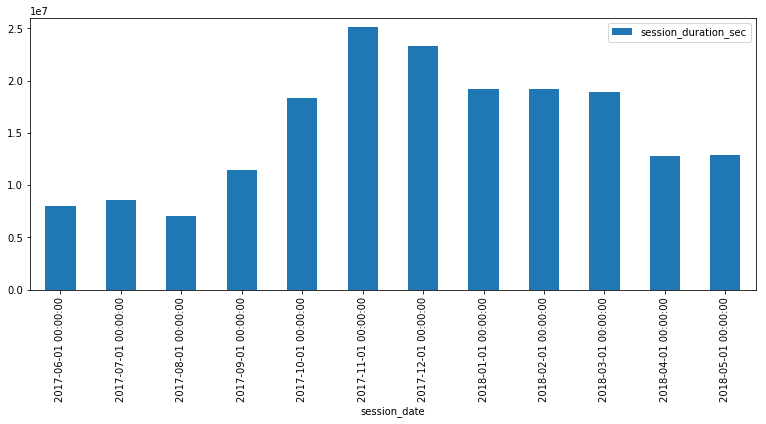

In [38]:
s_dur_min_desctop = dtop.pivot_table(index='session_date', values='session_duration_sec', aggfunc='sum')
s_dur_min_desctop.plot(kind='bar', figsize=(13, 5))
plt.ylim(0, 26000000)

Поведение пользователей настольных практически идентично мобильным, пик в ноябре - примерно 430000 проведенных в приложении часов.

### 4. Проверка гипотез. <a id='100104'></a>

### 4.1.Одинаковое ли время проводят пользователи двух видов устройств в Яндекс.Афише? <a id='104100'></a>

*Проверим гипотезу о том, что на обоих видах устройств, пользователи проводят одинаковое количество времени в Яндекс.Афише.Это будет нулевая гипотеза.*

In [39]:
#посчитаем дисперсию:
h8 = touch['session_duration_sec']
h9 = dtop['session_duration_sec']
variance_v_s = np.var(h8)
variance_v_u = np.var(h9)
print('Дисперсия данных о touch', variance_v_s)
print('Дисперсия данных о desctop', variance_v_u)

Дисперсия данных о touch 566758.736055933
Дисперсия данных о desctop 1193229.0023338536


In [40]:
#проверим гипотезу:
alpha = .05
results = st.ttest_ind(
    h8,
    h9, equal_var=False)
results.pvalue

if (results.pvalue < alpha):
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую') 

Отвергаем нулевую гипотезу


Отметим, что с настольных ПК в приложении пользователи проводят больше времени, причем на 47%. В дальнейшем нужно обратить на это внимание, при планировании рекламных кампаний и в технических моментах. Возможно провести дополнительное исследование, почему так происходит.

In [41]:
#исследуем связь отказов и используемого устройства: 
null_session_device = v2.pivot_table(index='device', values='session_duration_sec', aggfunc='count')
null_session_device

,session_duration_sec
device,
desktop,23689
touch,12105


### 4.2.Зависит ли процент отказов от вида устройства? <a id='104101'></a>

*Проверим гипотезу о том, что % отказов зависит от устройства, т.к. отказов со стационарных ПК больше, чем с мобильных. Нулевая - количество отказов равно и на мобильном и на стационарном ПК.*

In [42]:
v6 = touch.query('session_duration_sec == 0')
v7 = dtop.query('session_duration_sec == 0')
h6 = touch['session_duration_sec']
h7 = dtop['session_duration_sec']
#проверим гипотезу:
alpha = .05
results = st.ttest_ind(
    h6,
    h7, equal_var=False)
results.pvalue

if (results.pvalue < alpha):
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую') 

Отвергаем нулевую гипотезу


Нужно проверять почему отказов со стационарных ПК больше!

### 5.Исследование заказов. <a id='100105'></a>

In [43]:
#общая прибыль за год:
orders['revenue'].sum()

252053.77999999997

In [44]:
#количество покупок за год:
orders['uid'].count()

50414

In [45]:
#количество покупателей за год:
orders['uid'].value_counts().sum()

50414

### 5.1.Сколько людей совершают покупки впервые и продолжают покупать в следующих месяцах после совершения первой покупки. <a id='105100'></a>

In [46]:
first_order_date_buy = orders.groupby('uid')['buy_ts'].min()
first_order_date_buy.name = 'first_order_date'
orders = orders.join(first_order_date_buy,on='uid')
orders['first_order_month'] = orders['first_order_date'].astype('datetime64[M]')
orders['order_month'] = orders['buy_ts'].astype('datetime64[M]')
#orders.head()

In [47]:
first_ord = orders.pivot_table(index='first_order_month', values='revenue', aggfunc='sum')
first_ord

,revenue
first_order_month,
2017-06-01,24031.69
2017-07-01,16127.92
2017-08-01,11606.26
2017-09-01,34676.32
2017-10-01,27603.45
2017-11-01,26098.99
2017-12-01,33485.74
2018-01-01,16663.13
2018-02-01,16750.50


(0, 37000)

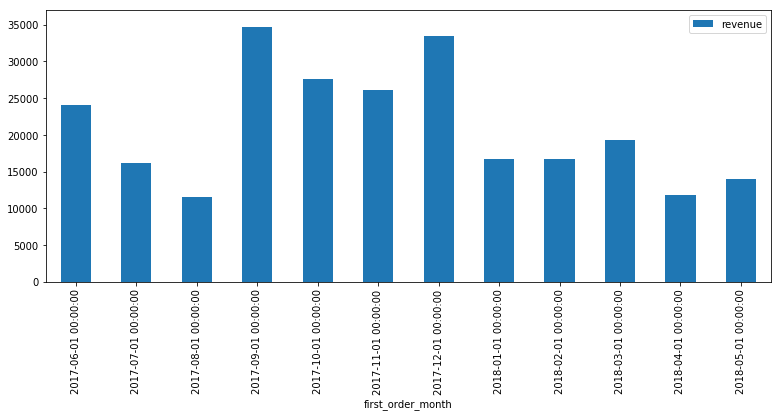

In [48]:
first_ord.plot(kind='bar', figsize=(13, 5))
plt.ylim(0, 37000)

Покупки начинаются с июня 2017 года c 24000, в июле спад на 33%, в августе по отношению к июлю еще на 28%, затем резкий рост в сентябре на 198%, в октябре-ноябре доход на уровне 26-27 тыс., в декабре снова рост до сентябрьского уровня, затем спад примерно на 40% и далее примерно на этом уровне до июня. В итоге самый высокий доход в сентябре и декабре, вторые по доходности октябрь - ноябрь, самый низкий доход в августе и апреле.

### 5.2.Активность пользователей по месяцам. <a id='105101'></a>

In [49]:
ord = orders.pivot_table(index='first_order_month', values='uid', aggfunc='count')
ord

,uid
first_order_month,
2017-06-01,4438
2017-07-01,2910
2017-08-01,2188
2017-09-01,3878
2017-10-01,6005
2017-11-01,5900
2017-12-01,5894
2018-01-01,4308
2018-02-01,4470


(0, 6500)

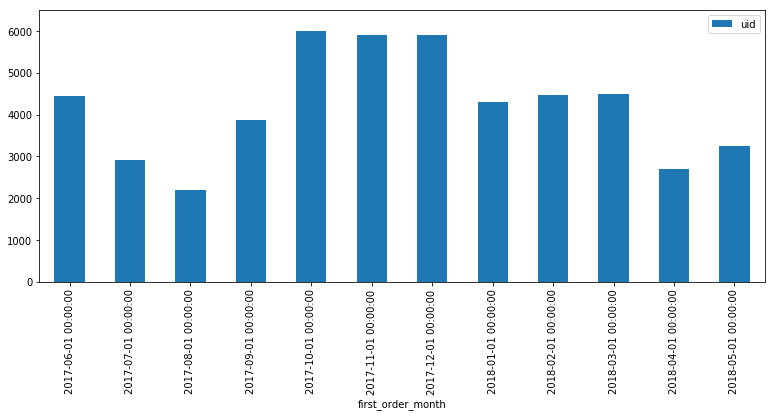

In [50]:
ord.plot(kind='bar', figsize=(13, 5))
plt.ylim(0, 6500)

В целом активность пользователей совпадает с прибылью по месяцам, но обращают на себя внимание месяц сентябрь 2017 активность средняя, а прибыль за этот месяц самая высокая.

### 5.3.Соотношение количества покупок и прибыли к пользователям по месяцам. <a id='105102'></a>

In [51]:
cohort_grouped = orders.groupby('first_order_month').agg({'buy_ts':'count', 'uid':'nunique','revenue':'sum'}).reset_index()
cohort_grouped

,first_order_month,buy_ts,uid,revenue
0,2017-06-01,4438,2023,24031.69
1,2017-07-01,2910,1923,16127.92
2,2017-08-01,2188,1370,11606.26
3,2017-09-01,3878,2581,34676.32
4,2017-10-01,6005,4340,27603.45
5,2017-11-01,5900,4081,26098.99
6,2017-12-01,5894,4383,33485.74
7,2018-01-01,4308,3373,16663.13
8,2018-02-01,4470,3651,16750.50
9,2018-03-01,4484,3533,19273.41


Нельзя сказать, что количество пользователей убывает, скорее явно видна сезонность, которую выявили ранее.

### 5.4.Насколько активно разные когорты покупают? Насколько дорогостоящие покупки? <a id='105103'></a>

(0, 3)

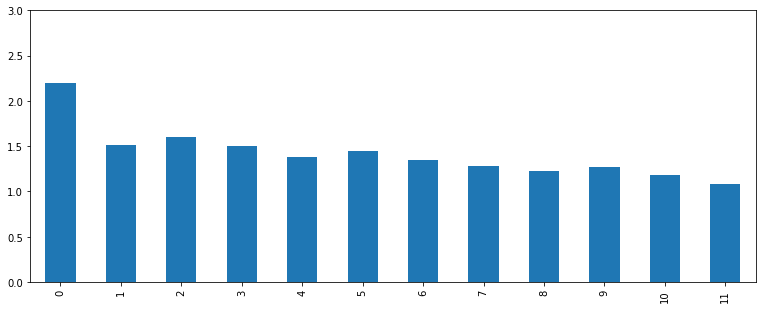

In [52]:
buying_activity = cohort_grouped['buy_ts'] / cohort_grouped['uid']
buying_activity.plot(kind='bar', figsize=(13, 5))
plt.ylim(0, 3)

Лучше всего покупательская активность в июньской когорте - более 2 покупок на человека.

(0, 10)

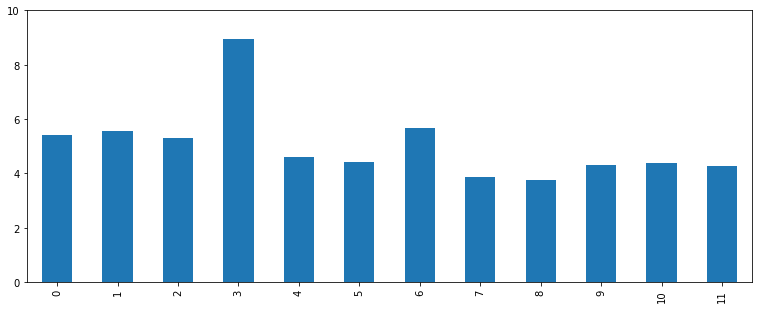

In [53]:
#посмотрим насколько дорогостоящие покупки, совпадает ли это с предыдущим графиком:
purchase_value = cohort_grouped['revenue'] / cohort_grouped['buy_ts']
purchase_value.plot(kind='bar', figsize=(13, 5))
plt.ylim(0, 10)

Оказалось, что самые дорогостоящие покупки делает все-же сентябрьская когорта, что подтвердило предыдущее наблюдение, что активность в когорте средняя, а прибыль самая высокая.

### 5.5.Как изменяется количество покупающих внутри одной когорты? <a id='105104'></a>

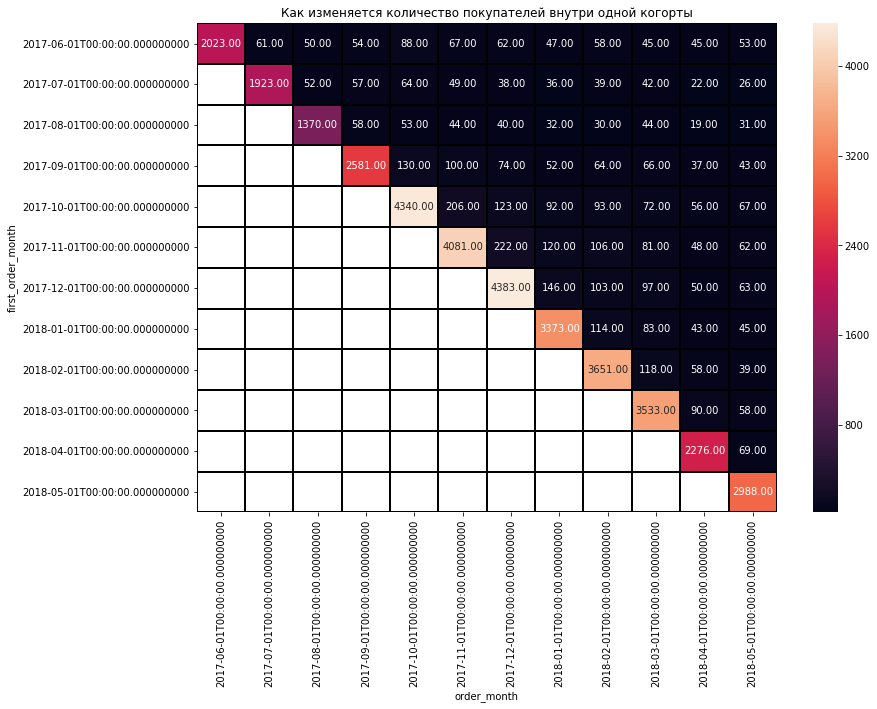

In [54]:
#посмотрим на относительные величины, как изменяется количество покупающих внутри одной когорты:
orders_pivot = orders.pivot_table(index='first_order_month',
    columns='order_month',
    values='uid',
    aggfunc='nunique')
plt.figure(figsize=(13, 9)) 
plt.title('Как изменяется количество покупателей внутри одной когорты') 
sns.heatmap(orders_pivot, annot=True, fmt='.2f', linewidths=1, linecolor='black')

Снова видна явная сезонность по притоку покупателей: ноябрь-январь, лучше всего покупают снова в следующие один-два месяца когорты с сентябрьской по январскую, но в целом количество постоянных покупок, довольно стабильно 40-60 в среднем в каждой когорте.

### 5.6.Относительные показатели по времени жизни. <a id='105105'></a>

In [55]:
orders_grouped_by_cohorts = orders.groupby(['first_order_month','order_month']).agg({'revenue':'sum','uid':'nunique'})

In [56]:
orders_grouped_by_cohorts['revenue_per_user'] = orders_grouped_by_cohorts['revenue'] / orders_grouped_by_cohorts['uid']
orders_grouped_by_cohorts_pivot = orders_grouped_by_cohorts.pivot_table(index='first_order_month',columns='order_month',values='revenue_per_user',aggfunc='mean')

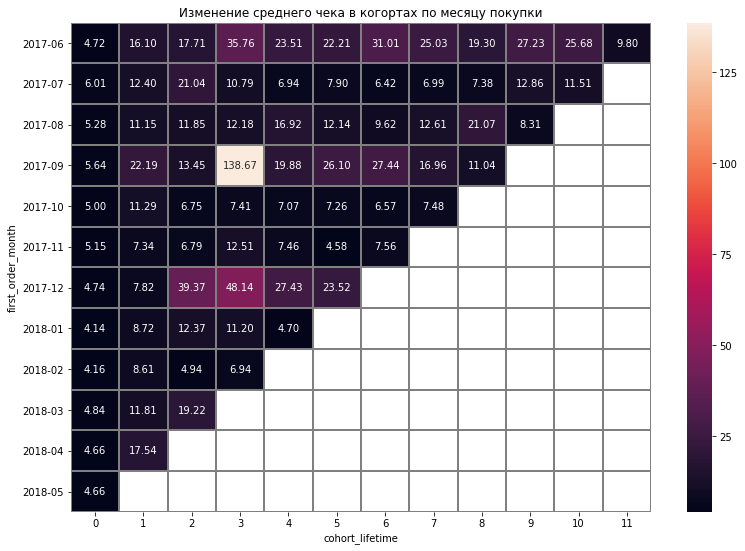

In [57]:
#lifetime когорты
orders_grouped_by_cohorts = orders_grouped_by_cohorts.reset_index()
orders_grouped_by_cohorts['cohort_lifetime'] = orders_grouped_by_cohorts['order_month'] - orders_grouped_by_cohorts['first_order_month']
orders_grouped_by_cohorts['cohort_lifetime'] = orders_grouped_by_cohorts['cohort_lifetime'] / np.timedelta64(1,'M')
orders_grouped_by_cohorts['cohort_lifetime'] = orders_grouped_by_cohorts['cohort_lifetime'].round().astype('int')
orders_grouped_by_cohorts['first_order_month'].dt.strftime('%d.%m.%Y')
orders_grouped_by_cohorts['first_order_month'] = orders_grouped_by_cohorts['first_order_month'].dt.strftime('%Y-%m')
revenue_per_user_pivot = orders_grouped_by_cohorts.pivot_table(index='first_order_month',columns='cohort_lifetime',values='revenue_per_user',aggfunc='mean')
plt.figure(figsize=(13, 9)) 
plt.title('Изменение среднего чека в когортах по месяцу покупки') 
sns.heatmap(revenue_per_user_pivot, annot=True, fmt='.2f', linewidths=1, linecolor='gray')
#сводная таблица изменения среднего чека, в столбцах lifetime, а строках — когорты

Вот и выявлена причина предыдущего вывода о том, что сентябрьская когорта делает самые дорогостоящие покупки, в среднем она покупает активно, но обращает на себя внимание какая-то крупная закупка в сентябре. Самые большие "средние чеки" у июньской, сентябрьской и декабрьской когорты.

### 5.7.Экономика одной продажи. LTV. <a id='105106'></a>

In [58]:
n_users = 50414
revenue_per_user = 5

var_costs = pd.Series({
    'marketing': 200000,
    'servers': 0
})

fixed_costs = pd.Series({
    'salaries': 329131,
    'rent': 0
})

revenue = n_users * revenue_per_user
total_costs = var_costs.sum() + fixed_costs.sum()
one_unit_revenue = revenue / n_users
one_unit_var_costs = var_costs / n_users

def unit_economics(marketing):    
    n_users = marketing / one_unit_var_costs['marketing']
    revenue = one_unit_revenue * n_users
    var_costs = one_unit_var_costs * n_users
    return revenue - sum(var_costs) - sum(fixed_costs)
for m in range(1000000, 1500000, 300000):
    print('Прибыль/убыток: {} при бюджете в {}'.format(unit_economics(m), m))

Прибыль/убыток: -68781.0 при бюджете в 1000000
Прибыль/убыток: 9324.0 при бюджете в 1300000


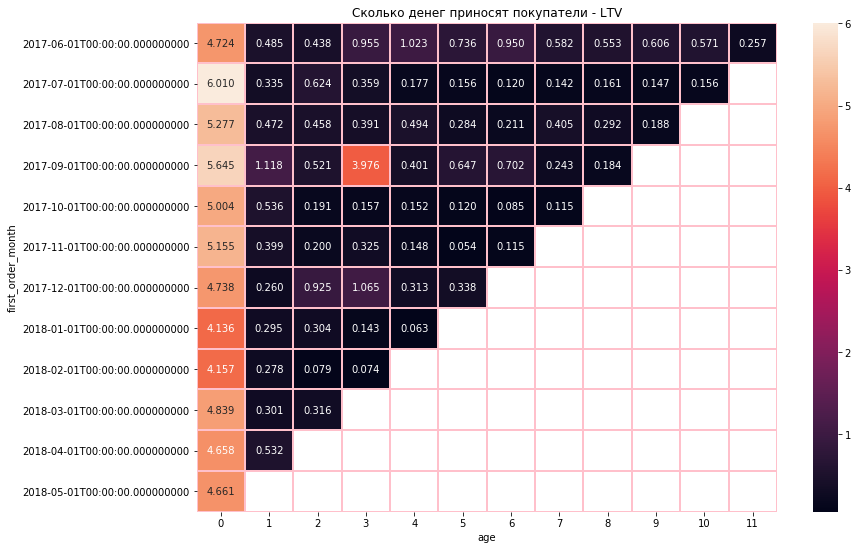

In [59]:
cost = costs
cost['month'] = cost['dt'].astype('datetime64[M]')

#посчитаем количество новых покупателей (n_buyers) за каждый месяц:
cohort_sizes = orders.groupby('first_order_month').agg({'uid': 'nunique'}).reset_index()
cohort_sizes.columns = ['first_order_month', 'n_buyers']
order_new = pd.merge(orders, first_order_date_buy, on= 'uid')

#сгруппируем когорты:
cohorts = orders.groupby(['first_order_month','order_month']).agg({'revenue': 'sum'}).reset_index()

#примем маржинальность за 100% , т.е. она будет равна столбцу revenue

report = pd.merge(cohort_sizes, cohorts, on='first_order_month')
report['age'] = (report['order_month'] - report['first_order_month']) / np.timedelta64(1, 'M')
report['age'] = report['age'].round().astype('int')
report['ltv'] = report['revenue'] / report['n_buyers']

output = report.pivot_table(index='first_order_month', columns='age', values='ltv', aggfunc='mean').round(3)
output.fillna('')
plt.figure(figsize=(13, 9)) 
plt.title('Сколько денег приносят покупатели - LTV') 
sns.heatmap(output, annot=True, fmt='.3f', linewidths=1, linecolor='pink')

In [60]:
ltv_june = output.loc['2017-06-01'].sum()
print('LTV июньской когорты:', ltv_june)
ltv_jule = output.loc['2017-07-01'].sum()
print('LTV июльской когорты:', ltv_jule)
ltv_august = output.loc['2017-08-01'].sum()
print('LTV августовской когорты:', ltv_august)
ltv_september = output.loc['2017-09-01'].sum()
print('LTV сентябрьской когорты:', ltv_september)
ltv_october = output.loc['2017-10-01'].sum()
print('LTV октябрьской когорты:', ltv_october)
ltv_november = output.loc['2017-11-01'].sum()
print('LTV ноябрьской когорты:', ltv_november)
ltv_dec = output.loc['2017-12-01'].sum()
print('LTV декабрьской когорты:', ltv_dec)
ltv_jan = output.loc['2018-01-01'].sum()
print('LTV январской когорты:', ltv_jan)
ltv_feb = output.loc['2018-02-01'].sum()
print('LTV февральской когорты:', ltv_feb)
ltv_march = output.loc['2018-03-01'].sum()
print('LTV мартовской когорты:', ltv_march)
ltv_apr = output.loc['2018-04-01'].sum()
print('LTV апрельской когорты:', ltv_apr)
ltv_may = output.loc['2018-05-01'].sum()
print('LTV майской когорты:', ltv_may)

LTV июньской когорты: 11.88
LTV июльской когорты: 8.387
LTV августовской когорты: 8.472000000000001
LTV сентябрьской когорты: 13.437
LTV октябрьской когорты: 6.359999999999999
LTV ноябрьской когорты: 6.396000000000001
LTV декабрьской когорты: 7.639
LTV январской когорты: 4.941
LTV февральской когорты: 4.588
LTV мартовской когорты: 5.456
LTV апрельской когорты: 5.19
LTV майской когорты: 4.661


Больше всего денег принесли покупатели сентябрьской когорты, а так же июньской, июльской и августовской из-за длительности пользования, а сентябрьской из-за крупной покупки.

### 6.Маркетинг. <a id='100106'></a>

### 6.1.Сколько всего денег потратили на привлечение? <a id='106100'></a>

In [61]:
#сколько денег всего потратили на привлечение:
cost['costs'].sum()

329131.62

(0, 37000)

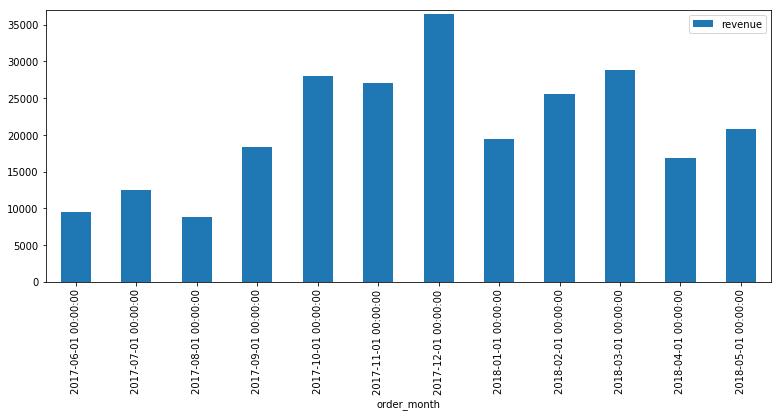

In [62]:
#построим график общих доходов для сравнения с затратами на рекламу:
orders.head()
income = orders.pivot_table(index='order_month', values='revenue', aggfunc='sum')
income.plot(kind='bar', figsize=(13, 5))
plt.ylim(0, 37000)

### 6.2.Расходы в месяц на рекламу. <a id='106101'></a>

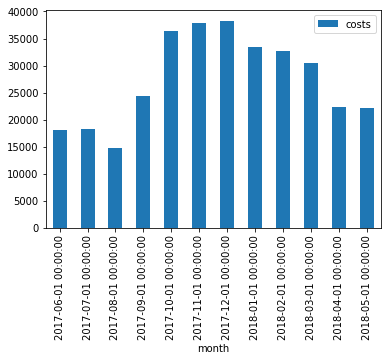

In [63]:
#расходы в месяц на рекламу
monthly_costs = cost.groupby('month').sum()
monthly_costs.plot(y='costs', kind='bar')

Пиковый период общих расходов на рекламу с октября по декабрь (35-40 тыс), далее небольшое снижение (30-35 тыс), в остальные месяцы в среднем 20000. Видна отдача в виде возросшего дохода в декабре, а вот в январе отдача очень низкая.

### 6.3.Сколько денег потрачено на каждый источник? <a id='106102'></a>

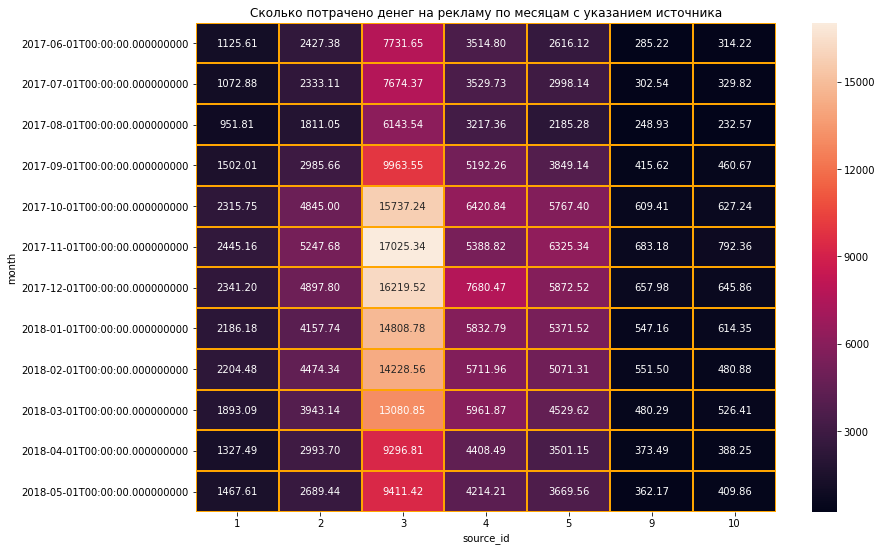

In [64]:
source_costs = costs.pivot_table(index='month', columns='source_id', values='costs', aggfunc='sum')

plt.figure(figsize=(13, 9)) 
plt.title('Сколько потрачено денег на рекламу по месяцам с указанием источника') 
sns.heatmap(source_costs, annot=True, fmt='.2f', linewidths=1, linecolor='orange')


Больше всего тратится на 3-й источник с октября по март. В целом этот перид затратен и во 2-м, 4-м и 5-м источнике, в 1-м период пиковых затрат слабо выражен. Наименее затратны 9 и 10 без пиков. Источники 6 и 7 не представлены, **видимо это бесплатные источники?? УТОЧНИТЬ!**

### 6.4.Расходы в месяц на рекламу по каждому рекламному источнику. <a id='106103'></a>

In [65]:
#зададим срезы по источникам

source1 = costs.query('source_id == 1')
source2 = costs.query('source_id == 2')
source3 = costs.query('source_id == 3')
source4 = costs.query('source_id == 4')
source5 = costs.query('source_id == 5')
source9 = costs.query('source_id == 9')
source10 = costs.query('source_id == 10')

#посмотрим расходы в месяц на рекламу по каждому источнику:
monthly_costs_1 = source1.groupby('month').sum()
monthly_costs_2 = source2.groupby('month').sum()
monthly_costs_3 = source3.groupby('month').sum()
monthly_costs_4 = source4.groupby('month').sum()
monthly_costs_5 = source5.groupby('month').sum()
monthly_costs_9 = source9.groupby('month').sum()
monthly_costs_10 = source10.groupby('month').sum()

### 6.5.Коррелируют ли расходы на рекламу с получением прибыли? <a id='106104'></a>

In [66]:
o1=orders
o1 = o1.groupby('order_month')['revenue'].sum().reset_index()
o1.columns = ('month', 'revenue')

In [67]:
c1 = cost
c1 = c1.pivot_table(index = 'month', values = 'costs', aggfunc = 'sum')
o1 = o1.join(c1, on='month')
o1_r = o1.corr()[['revenue', 'costs']]
o1_r

,revenue,costs
revenue,1.000000,0.899665
costs,0.899665,1.000000


Есть прямая взаимосвязь между расходами на рекламу и доходами - коэффициент корреляции = 0,9.

**1 ИСТОЧНИК**

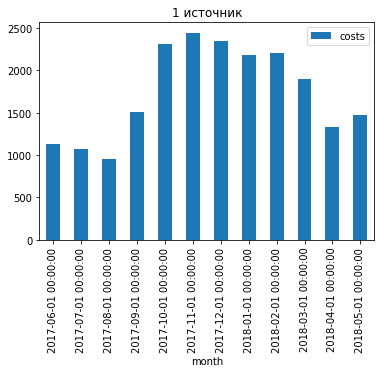

In [68]:
monthly_costs_1.plot(y='costs', title = '1 источник', kind='bar')

In [69]:
source1 = source1.pivot_table(index = 'month', values = 'costs', aggfunc = 'sum').reset_index()
o1 = pd.merge(o1, source1, on='month')
o1.head()
#korr11 = o1.corr()[['revenue', 'costs_y']]
#korr11

,month,revenue,costs_x,costs_y
0,2017-06-01,9557.49,18015.00,1125.61
1,2017-07-01,12539.47,18240.59,1072.88
2,2017-08-01,8758.78,14790.54,951.81
3,2017-09-01,18345.51,24368.91,1502.01
4,2017-10-01,27987.70,36322.88,2315.75


Самые высокие расходы на рекламу в первом источнике приходится на период с октября 2017 по март 2018. В эти месяцы расходы не превышают 2500 в остальные в среднем 1100-1500. Корреляция с выручкой - 0,788.

**2 ИСТОЧНИК**

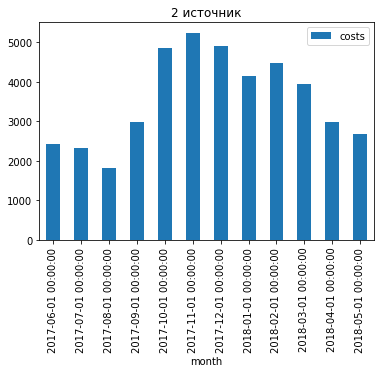

In [70]:
monthly_costs_2.plot(y='costs', title = '2 источник', kind='bar')

In [71]:
source2 = source2.pivot_table(index = 'month', values = 'costs', aggfunc = 'sum').reset_index()
o2 = pd.merge(o1, source2, on='month')
korr22 = o2.corr()[['revenue', 'costs_y']]
#korr22

Пик расходов на рекламу во втором источнике приходятся на период с октября по декабрь 2018 (около 5000), чуть ниже в начале 2018-го, в среднем 4000, в апреле-мае 2018 около 3000 и самые низкие в летние месяцы 2017-го, в среднем 2000. Корреляция с выручкой - 0,802.

**3 ИСТОЧНИК**

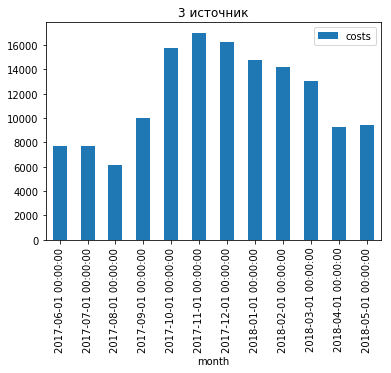

In [72]:
monthly_costs_3.plot(y='costs', title = '3 источник', kind='bar')

In [73]:
source3 = source3.pivot_table(index = 'month', values = 'costs', aggfunc = 'sum').reset_index()
o3 = pd.merge(o1, source3, on='month')
korr33 = o3.corr()[['revenue', 'costs_y']]
#korr33

Самый затратный источник из всех, пик расходов в ноябре около 17000, самые большие расходы в период с октября 2017 по март 2018. В остальные месяцы затраты в 2 раза меньше. Корреляция с выручкой - 0,796.

**4 ИСТОЧНИК**

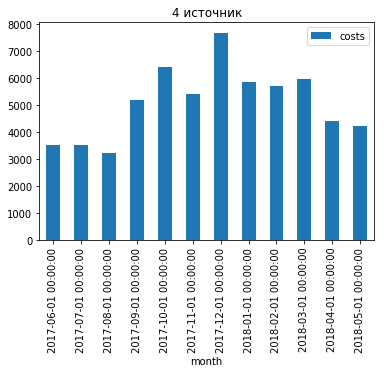

In [74]:
monthly_costs_4.plot(y='costs', title = '4 источник', kind='bar')

In [75]:
source4 = source4.pivot_table(index = 'month', values = 'costs', aggfunc = 'sum').reset_index()
o4 = pd.merge(o1, source4, on='month')
korr44 = o4.corr()[['revenue', 'costs_y']]
#korr44

Самые высокие затраты на рекламу 4-го источника в декабре (более 7500), с сентября 2017 по март 2018 около 6000, в остальные месяцы, в среднем 4000. Корреляция с выручкой - 0,887.

**5 ИСТОЧНИК**

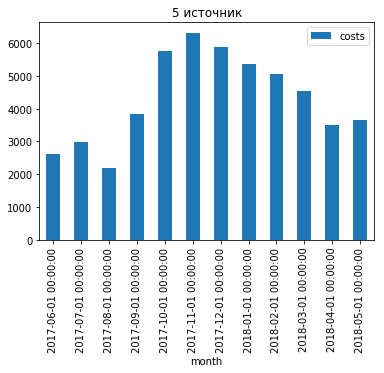

In [76]:
monthly_costs_5.plot(y='costs', title = '5 источник', kind='bar')

In [77]:
source5 = source5.pivot_table(index = 'month', values = 'costs', aggfunc = 'sum').reset_index()
o5 = pd.merge(o1, source5, on='month')
korr55 = o5.corr()[['revenue', 'costs_y']]
#korr55

В 5-м источнике так же, как и в предыдущих пик расходов с октября по март (в среднем 5500). В остальное время практически в 2 раза меньше. Корреляция с выручкой - 0,778.

**9 ИСТОЧНИК**

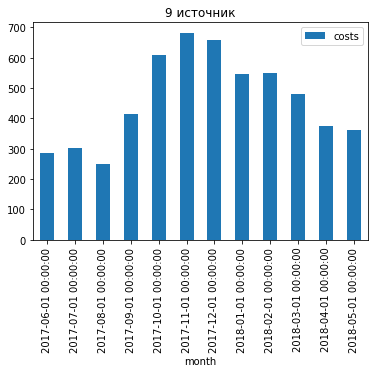

In [78]:
monthly_costs_9.plot(y='costs', title = '9 источник', kind='bar')

In [79]:
source9 = source9.pivot_table(index = 'month', values = 'costs', aggfunc = 'sum').reset_index()
o9 = pd.merge(o1, source9, on='month')
korr99 = o9.corr()[['revenue', 'costs_y']]
#korr99

У 9-го источника маленькие расходы на рекламу с таким же распределением по месяцам, как и у предыдущих. Октябрь-март в среднем 550 в месяц, в остальное время, в среднем 350. Корреляция с выручкой - 0,801.

**10 ИСТОЧНИК**

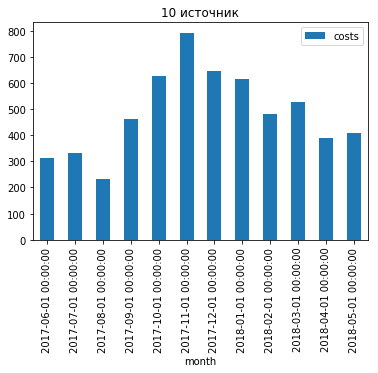

In [80]:
monthly_costs_10.plot(y='costs', title = '10 источник', kind='bar')

In [81]:
source10 = source10.pivot_table(index = 'month', values = 'costs', aggfunc = 'sum').reset_index()
o10 = pd.merge(o1, source10, on='month')
korr100 = o10.corr()[['revenue', 'costs_y']]
#korr100

У 10-го источника пик в ноябре 2017 - 800, самые низкие расходы летом 2017 - 250-300. Корреляция с выручкой - 0,708.

**Все источники похожи - пик расходов приходится на ноябрь, кроме 4-го, у него пик в декабре.**
****************

### 6.6.САС (стоимость привлечения одного клиента) и ROMI для каждого источника. <a id='106105'></a>

(0, 0.75)

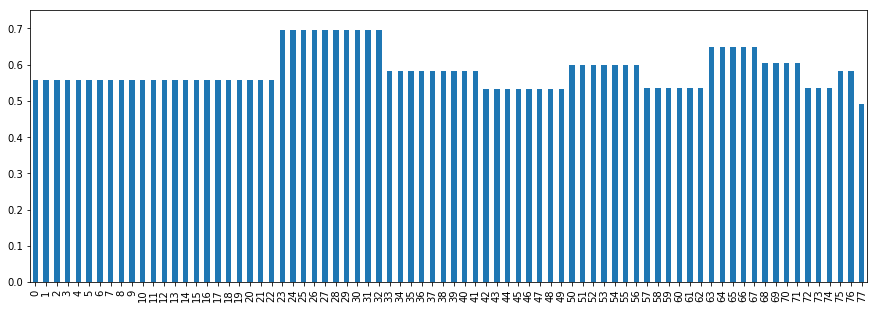

In [82]:
#1 источник:
report_new_1 = pd.merge(report, monthly_costs_1, left_on='first_order_month', right_on='month')

report_new_1['cac'] = report_new_1['costs'] / report_new_1['n_buyers']
report_new_1['cac'].plot(kind='bar', figsize=(15, 5))
plt.ylim(0, 0.75)

В 1-м источнике привлечение клиентов дороже всего в августе и в январе. В среднем привлечение одного клиента обходится в 0,55 р.

**Посчитаем ROMI 1 источника**

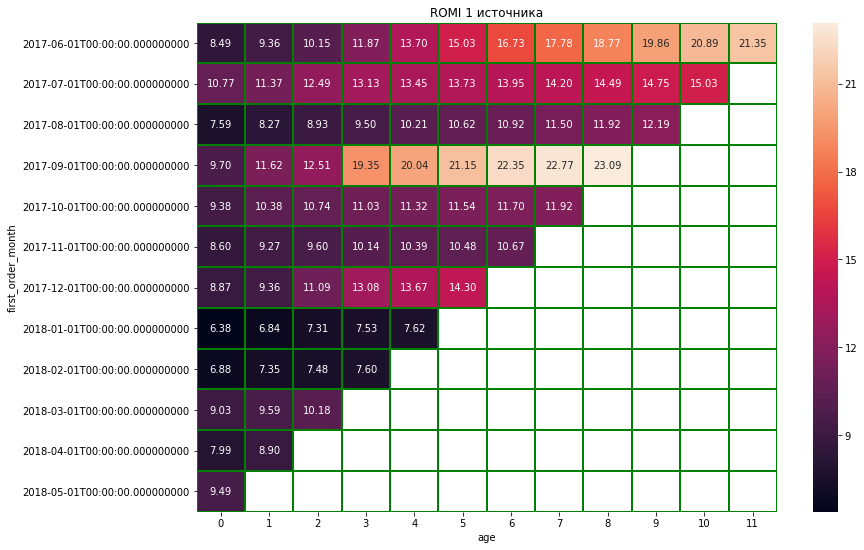

In [83]:
#посчитаем ROMI 1 источника
report_new_1['ltv'] = report_new_1['revenue'] / report_new_1['n_buyers']
report_new_1['romi'] = report_new_1['ltv'] / report_new_1['cac']
output10 = report_new_1.pivot_table(index='first_order_month', columns='age', values='romi', aggfunc='mean')

output11 = output10.cumsum(axis=1).round(2)
plt.figure(figsize=(13, 9)) 
plt.title('ROMI 1 источника') 
sns.heatmap(output11, annot=True, fmt='.2f', linewidths=1, linecolor='green')

* **1 источник полностью окупается и даже более**
****************

(0, 1.4)

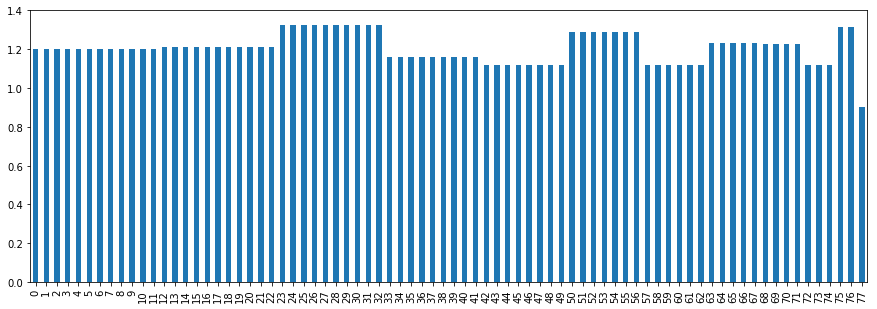

In [84]:
#2 источник:
report_new_2 = pd.merge(report, monthly_costs_2, left_on='first_order_month', right_on='month')
report_new_2['cac'] = report_new_2['costs'] / report_new_2['n_buyers']
report_new_2['cac'].plot(kind='bar', figsize=(15, 5))
plt.ylim(0, 1.4)

Во 2-м источнике привлечение клиентов дороже всего в апреле, августе и в ноябре. В среднем привлечение одного клиента обходится в 1,1 р.

**Посчитаем ROMI 2 источника**

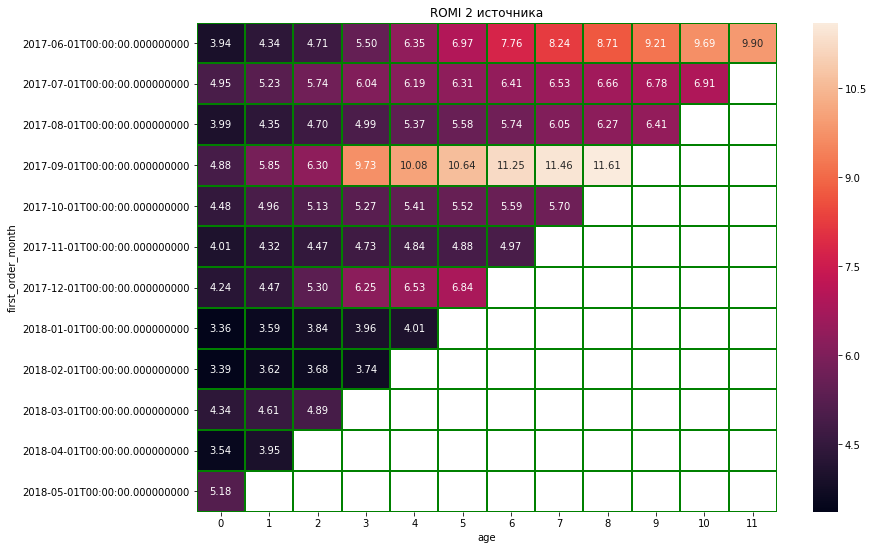

In [85]:
#посчитаем ROMI 2 источника
report_new_2['ltv'] = report_new_2['revenue'] / report_new_2['n_buyers']
report_new_2['romi'] = report_new_2['ltv'] / report_new_2['cac']
output20 = report_new_2.pivot_table(index='first_order_month', columns='age', values='romi', aggfunc='mean')

output21 = output20.cumsum(axis=1).round(2)
plt.figure(figsize=(13, 9)) 
plt.title('ROMI 2 источника') 
sns.heatmap(output21, annot=True, fmt='.2f', linewidths=1, linecolor='green')

* **2 источник окупается**
*******************

(0, 4.75)

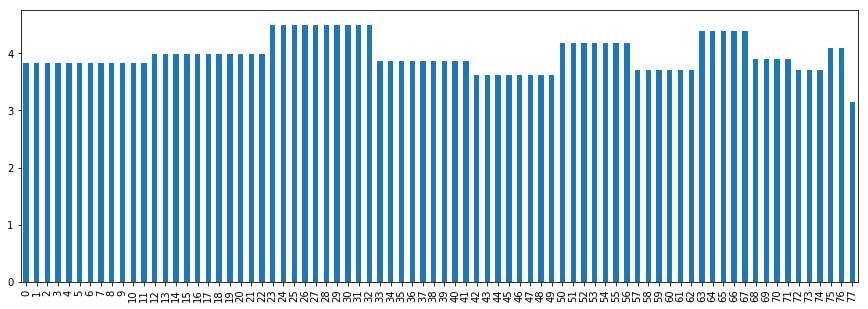

In [86]:
#3 источник:
report_new_3 = pd.merge(report, monthly_costs_3, left_on='first_order_month', right_on='month')
report_new_3['cac'] = report_new_3['costs'] / report_new_3['n_buyers']
report_new_3['cac'].plot(kind='bar', figsize=(15, 5))
plt.ylim(0, 4.75)

В 3-м источнике привлечение клиентов дороже всего в августе и в январе. В среднем привлечение одного клиента обходится в 4 р.

**Посчитаем ROMI 3 источника**

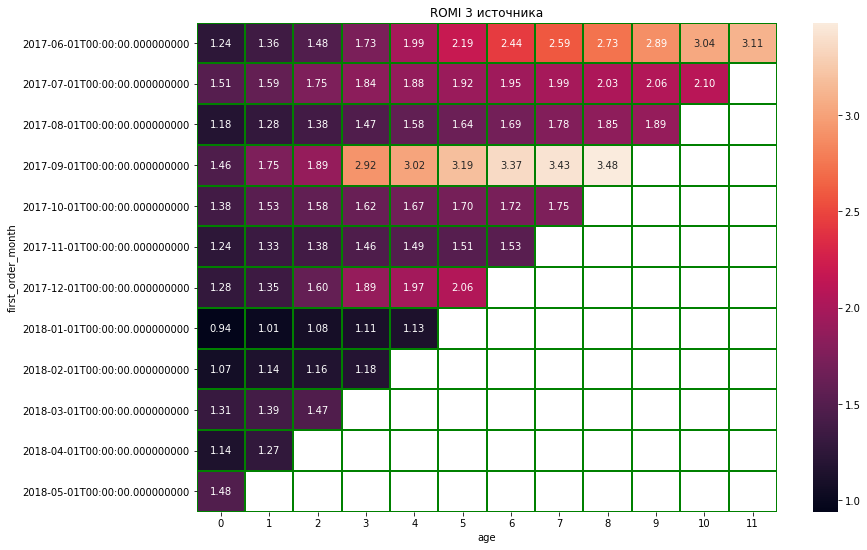

In [87]:
#посчитаем ROMI 3 источника
report_new_3['ltv'] = report_new_3['revenue'] / report_new_3['n_buyers']
report_new_3['romi'] = report_new_3['ltv'] / report_new_3['cac']
output30 = report_new_3.pivot_table(index='first_order_month', columns='age', values='romi', aggfunc='mean')

output31 = output30.cumsum(axis=1).round(2)
plt.figure(figsize=(13, 9)) 
plt.title('ROMI 3 источника') 
sns.heatmap(output31, annot=True, fmt='.2f', linewidths=1, linecolor='green')

3 источник, при очень больших затратах, окупается с трудом.
******************

(0, 2.5)

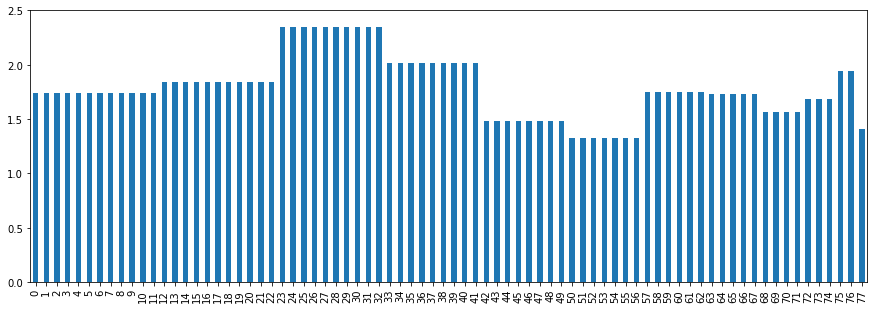

In [88]:
#4 источник:
report_new_4 = pd.merge(report, monthly_costs_4, left_on='first_order_month', right_on='month')
report_new_4['cac'] = report_new_4['costs'] / report_new_4['n_buyers']
report_new_4['cac'].plot(kind='bar', figsize=(15, 5))
plt.ylim(0, 2.5)

В 4-м источнике привлечение клиентов дороже всего в августе. В среднем привлечение одного клиента обходится в 1,75 р.

**Посчитаем ROMI 4 источника**

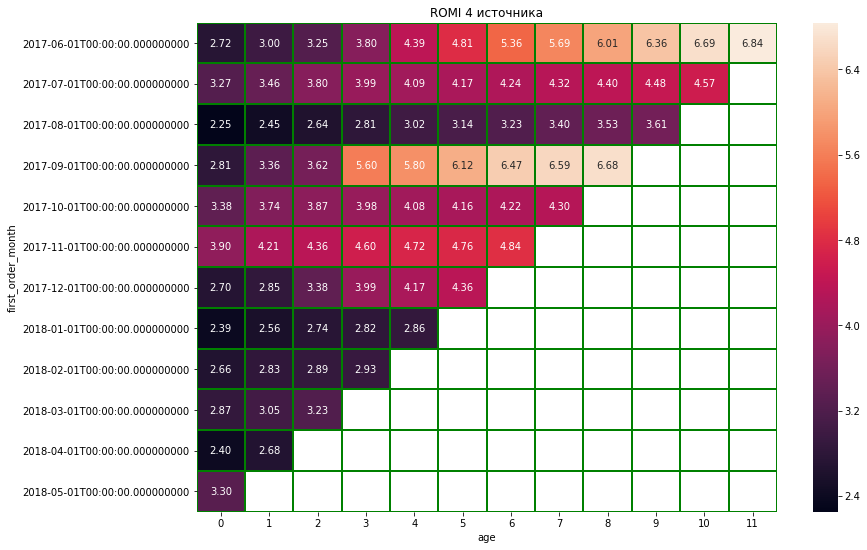

In [89]:
#посчитаем ROMI 4 источника
report_new_4['ltv'] = report_new_4['revenue'] / report_new_4['n_buyers']
report_new_4['romi'] = report_new_4['ltv'] / report_new_4['cac']
output40 = report_new_4.pivot_table(index='first_order_month', columns='age', values='romi', aggfunc='mean')

output41 = output40.cumsum(axis=1).round(2)
plt.figure(figsize=(13, 9)) 
plt.title('ROMI 4 источника') 
sns.heatmap(output41, annot=True, fmt='.2f', linewidths=1, linecolor='green')

4 источник окупается.
*****************

(0, 1.75)

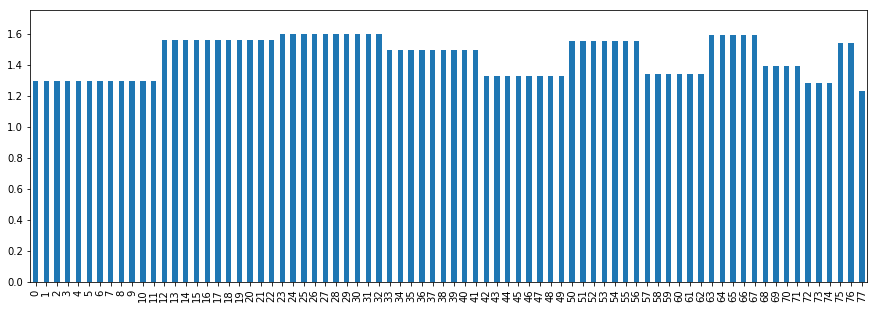

In [90]:
#5 источник:
report_new_5 = pd.merge(report, monthly_costs_5, left_on='first_order_month', right_on='month')
report_new_5['cac'] = report_new_5['costs'] / report_new_5['n_buyers']
report_new_5['cac'].plot(kind='bar', figsize=(15, 5))
plt.ylim(0, 1.75)

В 5-м источнике привлечение клиентов дороже всего в январе. В среднем привлечение одного клиента обходится в 1,4 р.

**Посчитаем ROMI 5 источника**

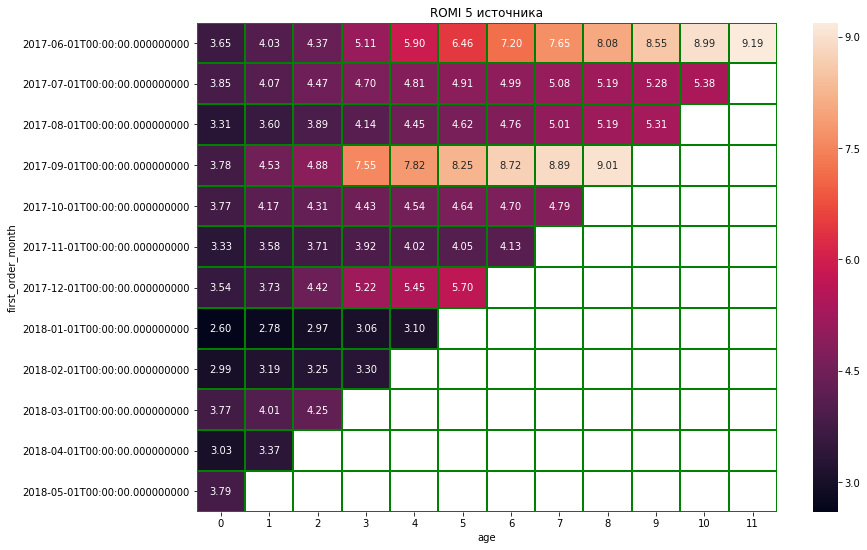

In [91]:
#посчитаем ROMI 5 источника
report_new_5['ltv'] = report_new_5['revenue'] / report_new_5['n_buyers']
report_new_5['romi'] = report_new_5['ltv'] / report_new_5['cac']
output50 = report_new_5.pivot_table(index='first_order_month', columns='age', values='romi', aggfunc='mean')

output51 = output50.cumsum(axis=1).round(2)
plt.figure(figsize=(13, 9)) 
plt.title('ROMI 5 источника') 
sns.heatmap(output51, annot=True, fmt='.2f', linewidths=1, linecolor='green')

5 источник окупается.
**************

(0, 0.2)

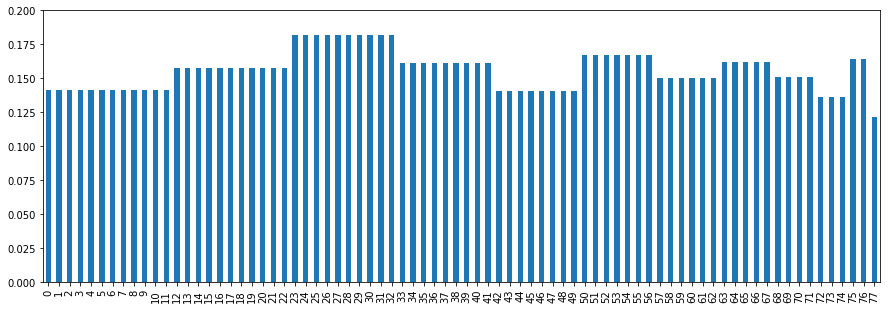

In [92]:
#9 источник:
report_new_9 = pd.merge(report, monthly_costs_9, left_on='first_order_month', right_on='month')
report_new_9['cac'] = report_new_9['costs'] / report_new_9['n_buyers']
report_new_9['cac'].plot(kind='bar', figsize=(15, 5))
plt.ylim(0, 0.2)

В 9-м источнике привлечение клиентов дороже всего в августе. В среднем привлечение одного клиента обходится в 0,14 р.

**Посчитаем ROMI 9 источника**

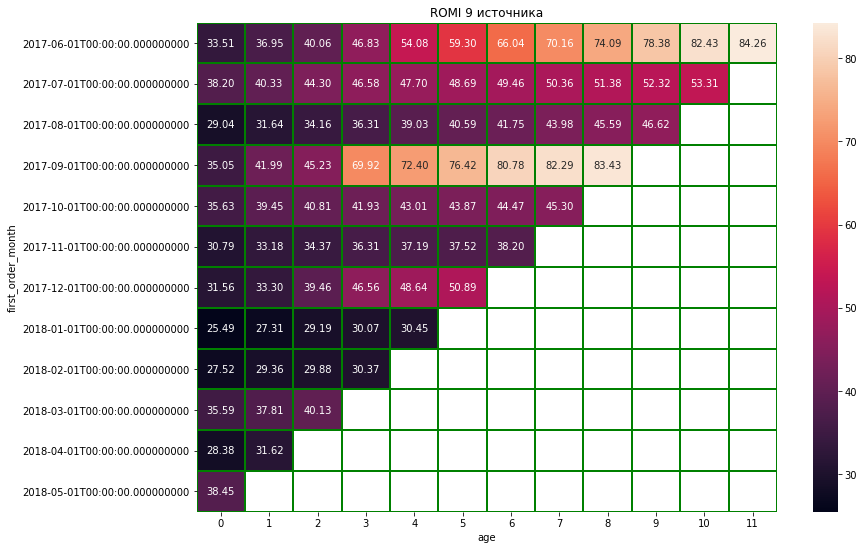

In [93]:
#посчитаем ROMI 9 источника
report_new_9['ltv'] = report_new_9['revenue'] / report_new_9['n_buyers']
report_new_9['romi'] = report_new_9['ltv'] / report_new_9['cac']
output90 = report_new_9.pivot_table(index='first_order_month', columns='age', values='romi', aggfunc='mean')

output91 = output90.cumsum(axis=1).round(2)
plt.figure(figsize=(13, 9)) 
plt.title('ROMI 9 источника') 
sns.heatmap(output91, annot=True, fmt='.2f', linewidths=1, linecolor='green')

9 источник окупается, в среднем, более чем в 30 раз!
*****************

(0, 0.25)

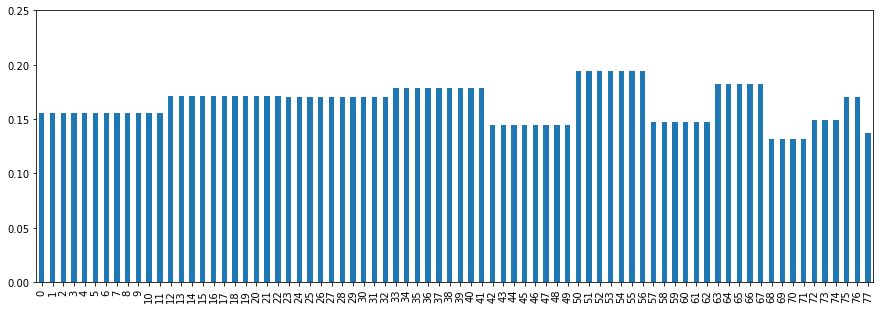

In [94]:
#10 источник:
report_new_10 = pd.merge(report, monthly_costs_10, left_on='first_order_month', right_on='month')
report_new_10['cac'] = report_new_10['costs'] / report_new_10['n_buyers']
report_new_10['cac'].plot(kind='bar', figsize=(15, 5))
plt.ylim(0, 0.25)

В 10-м источнике привлечение клиентов дороже всего в ноябре. В среднем привлечение одного клиента обходится в 0,15 р.

**Так же нужно отметить общее для всех источников, дешевле всего привлечение обходится в мае, кроме 10-го источника здесь этот период в феврале.**

**Посчитаем ROMI 10 источника**

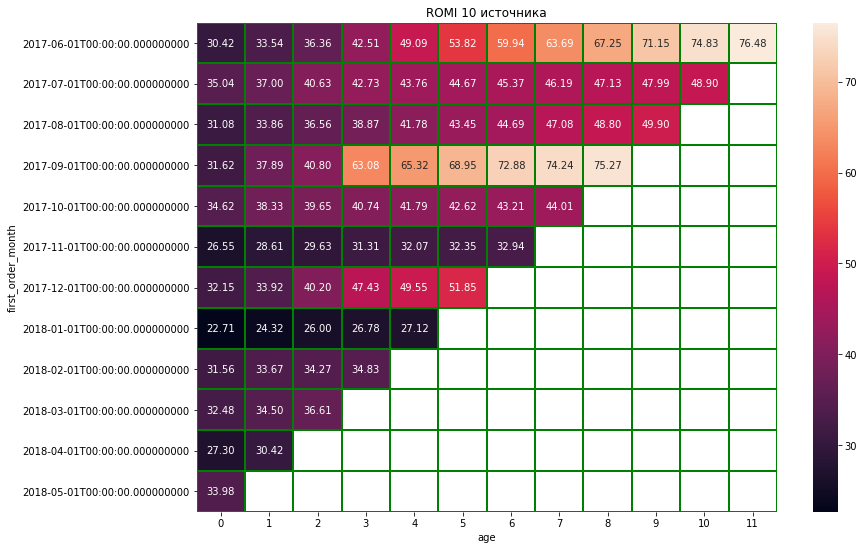

In [95]:
#посчитаем ROMI 10 источника
report_new_10['ltv'] = report_new_10['revenue'] / report_new_10['n_buyers']
report_new_10['romi'] = report_new_10['ltv'] / report_new_10['cac']

output100 = report_new_10.pivot_table(index='first_order_month', columns='age', values='romi', aggfunc='mean')

output101 = output100.cumsum(axis=1).round(2)
output101
plt.figure(figsize=(13, 9)) 
plt.title('ROMI 10 источника')
sns.heatmap(output101, annot=True, fmt='.2f', linewidths=1, linecolor='green')

И 10 источник окупается более чем в 30 раз!
***************

### 6.7.Когда окупается клиент? <a id='106106'></a>

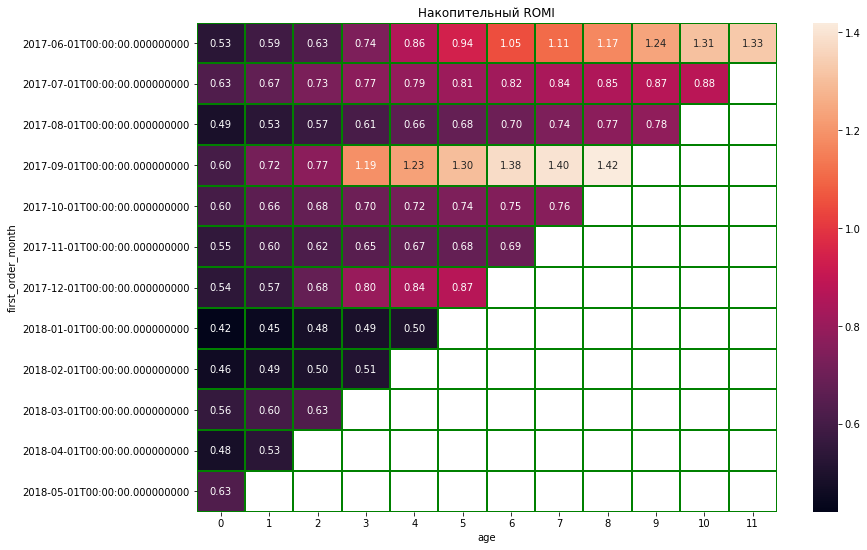

In [96]:
#посчитаем накопительный ROMI
monthly_costs = costs.groupby('month').sum()
report_new = pd.merge(report, monthly_costs, left_on='first_order_month', right_on='month')
report_new['cac'] = report_new['costs'] / report_new['n_buyers']
report_new['romi'] = report_new['ltv'] / report_new['cac']
output10 = report_new.pivot_table(index='first_order_month', columns='age', values='romi', aggfunc='mean')

output20 = output10.cumsum(axis=1).round(2)
plt.figure(figsize=(13, 9)) 
plt.title('Накопительный ROMI') 
sns.heatmap(output20, annot=True, fmt='.2f', linewidths=1, linecolor='green')

### 6.8.Как быстро окупаются когорты? <a id='106107'></a>

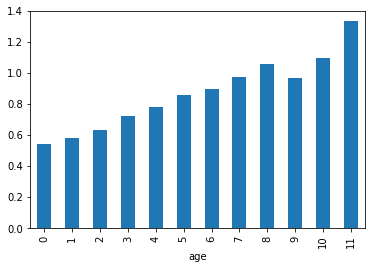

In [97]:
#как быстро вообще когорты окупаются:
output3 = output10.cumsum(axis=1).mean(axis=0)
output3.plot(y='age', kind='bar')

В среднем клиент окупается через 8 месяцев, но есть исключения из-за дорогостоящей покупки(или краткосрочного пика продаж сентябрьская когорта окупилась, через 4 месяца, т.е. в 2 раза быстрее. Так же выделяется июньская когорта - она окупилась на 7-й месяц. И близка к окупаемости декабрькая когорта.

### 7. Выводы: <a id='100107'></a>

**Количество посетителей за год: 358520
Распределение посетителей по разным рекламным источникам:
4     101649
3      85447
5      66709
2      47471
1      33941
9      13257
10     10004
7         36
6          6**

Сессия длится, в среднем:   60 секунд.


**DAU (количество уникальных пользователей в день) - 907
WAU (количество уникальных пользователей в неделю) - 5716
MAU (количество уникальных пользователей в месяц) – 23227**

Как часто люди возвращаются:
регулярность использования по отношению к месячной аудитории:  3.91,
регулярность использования по отношению к недельной аудитории: 15.88.

**Количество пользователей мобильных ПК: 96615
Количество пользователей настольных ПК: 261905
Количество пользователей настольных компьютеров в 2.7 раза больше чем мобильных.
Количество отказов: 35794**

ПРОБЛЕМЫ:

**Из данных видно, что есть сессии и по 5 и даже 23 часа. ОБРАТИТЬ ВНИМАНИЕ!
Отказы есть по всем рекламным кампаниям и  примерно 10% довольно высок, необходимо проверить на предмет проблем в технической части обеспечения рекламной кампании.
Рекламные источники 6 и 7 практически не представлены, похоже на аномалии. ОБРАТИТЬ ВНИМАНИЕ! А так же при проверке расходов на рекламные источники,  6 и 7 не представлены вообще, видимо это бесплатные источники. УТОЧНИТЬ! Была проверена гипотеза и выявлено, что отказов со стационарных ПК больше, требуется проверка!**

Если разделить данные по используемым устройствам то:

1.	Touch (мобильные ПК)
Расходы на 4 рекламный источник здесь самые большие, так же растут и расходы на все источники начиная с октября 2017. Минимальные расходы на источники 9 и 10.
Резкий рост использования наблюдается с октября 2017 по март 2018 включительно, пик приходится на ноябрь - примерно 105000 часов. Нужно изучить влияние погоды/времени года и новых премьер!

2.	Desctop (стационарные ПК)
Расходы в данной категории на 3 и 4 источник самые большие и близки друг к другу, так же растут и расходы на все источники начиная с октября 2017, следовательно это общая тенденция. Минимальные расходы на источники 9 и 10.
Поведение пользователей настольных практически идентично мобильным, пик в ноябре - примерно 430000 проведенных в приложении часов. Отметим, что с настольных ПК в приложении пользователи проводят больше времени, причем на 47%. В дальнейшем нужно обратить на это внимание, при планировании рекламных кампаний и в технических моментах. Возможно провести дополнительное исследование, почему так происходит.

**Количество отказов у desktop – 23689, а у touch – 12105.**

Общая прибыль за год: 252053

С большим отрывом лидирует прибыль полученная со стационарных компьютеров, пик доходов от них приходится на декабрь, минимальный доход в июле-августе. У мобильных ПК максимум в ноябре.

**Количество покупок за год: 50414**

Покупки начинаются с июня 2017 года c 24000, в июле спад на 33%, в августе по отношению к июлю еще на 28%, затем резкий рост в сентябре на 198%, в октябре-ноябре доход на уровне 26-27 тыс., в декабре снова рост до сентябрьского уровня, затем спад примерно на 40% и далее примерно на этом уровне до июня. В итоге самый высокий доход в сентябре и декабре, вторые по доходности октябрь - ноябрь, самый низкий доход в августе и апреле.

**В целом активность пользователей совпадает с прибылью по месяцам, но обращают на себя внимание месяц сентябрь 2017 активность средняя, а прибыль за этот месяц самая высокая. Выяснилось, что была крупная покупка в сентябре, прпи средней активности, прибыль самая высокая. Возможно аномалия – проверить!**

Соотношение количества покупок и прибыли к пользователям по месяцам:
нельзя сказать, что количество пользователей убывает, скорее явно видна сезонность, которую выявили ранее. 
Лучше всего покупательская активность в июньской когорте - более 2 покупок на человека. 
Явная сезонность подтверждает  приток покупателей: ноябрь-январь, лучше всего покупают снова в следующие один-два месяца когорты с сентябрьской по январскую, но в целом количество постоянных покупок, довольно стабильно 40-60 в среднем в каждой когорте. 

**Самые большие "средние чеки" у июньской, сентябрьской и декабрьской когорты.
LTV июньской когорты: 11.88
LTV июльской когорты: 8.387
LTV августовской когорты: 8.472000000000001
LTV сентябрьской когорты: 13.437
LTV октябрьской когорты: 6.359999999999999
LTV ноябрьской когорты: 6.396000000000001
LTV декабрьской когорты: 7.639
LTV январской когорты: 4.941
LTV февральской когорты: 4.588
LTV мартовской когорты: 5.456
LTV апрельской когорты: 5.19
LTV майской когорты: 4.661**

Больше всего денег (LTV) принесли покупатели сентябрьской когорты (уточнить не аномилия ли!), а так же июньской, июльской и августовской из-за длительности пользования, а сентябрьской из-за крупной закупки.

**Сколько денег всего потрачено на привлечение: 329131**

Расходы в месяц на рекламу: Пиковый период общих расходов на рекламу с октября по декабрь (35-40 тыс), далее небольшое снижение (30-35 тыс), в остальные месяцы в среднем 20000.
Больше всего тратится на 3-й источник с октября по март. В целом этот перид затратен и во 2-м, 4-м и 5-м источнике, в 1-м период пиковых затрат слабо выражен. Наименее затратны 9 и 10 без пиков.

**Есть прямая взаимосвязь между расходами на рекламу и доходами - коэффициент корреляции = 0,9.**

ПО ИСТОЧНИКАМ:
- самые высокие расходы на рекламу в первом источнике приходятся на период с октября 2017 по март 2018. В эти месяцы расходы не превышают 2500 в остальные в среднем 1100-1500. Видна отдача в виде возросшего дохода в декабре, а вот в январе отдача очень низкая. Коэффициент корреляции по отдельным источникам подтверждает общий коэффициент корреляции.
- пик расходов на рекламу во втором источнике приходится на период с октября по декабрь 2018 (около 5000), чуть ниже в начале 2018-го, в среднем 4000, в апреле-мае 2018 около 3000 и самые низкие в летние месяцы 2017-го, в среднем 2000.
- самый затратный источник из всех, пик расходов в ноябре около 17000, самые большие расходы в период с октября 2017 по март 2018. В остальные месяцы затраты в 2 раза меньше.
 - самые высокие затраты на рекламу 4-го источника в декабре (более 7500), с сентября 2017 по март 2018 около 6000, в сотальные месяцы, в среднем 4000.
 - в 5-м источнике так же, как и в предыдущих пик расходов с октября по март (в среднем 5500). В остальное время практически в 2 раза меньше.
- у 9-го источника маленькие расходы на рекламу с таким же распределением по месяцам, как и у предыдущих. Октябрь-март в среднем 550 в месяц, в остальное время, в среднем 350.
- у 10-го источника пик в ноябре 2017 - 800, самые низкие расходы летом 2017 - 250-300.

Все источники похожи - пик расходов приходится на ноябрь, кроме 4-го, у него пик в декабре.

**САС**
- в 1-м источнике привлечение клиентов дороже всего в августе и в январе. В среднем привлечение одного клиента обходится в 0,55.
- во 2-м источнике привлечение клиентов дороже всего в августе и в ноябре. В среднем привлечение одного клиента обходится в 1,1.
- вВ 3-м источнике привлечение клиентов дороже всего в августе и в январе. В среднем привлечение одного клиента обходится в 4.
- в 4-м источнике привлечение клиентов дороже всего в августе. В среднем привлечение одного клиента обходится в 1,75 р.
- в 5-м источнике привлечение клиентов дороже всего в январе. В среднем привлечение одного клиента обходится в 1,4 р.
- в 9-м источнике привлечение клиентов дороже всего в августе. В среднем привлечение одного клиента обходится в 0,14 р.
- в 10-м источнике привлечение клиентов дороже всего в ноябре. В среднем привлечение одного клиента обходится в 0,15 р.

**Общее для всех источников -  дешевле всего привлечение обходится в мае, кроме 10-го источника здесь этот период в феврале.**

В среднем, клиент окупается через 8 месяцев, но есть исключения из-за дорогостоящей покупки(или краткосрочного пика продаж сентябрьская когорта окупилась, через 4 месяца, т.е. в 2 раза быстрее. Так же выделяется июньская когорта - она окупилась на 7-й месяц. И близка к окупаемости декабрькая когорта.


### 8. Рекомендации: <a id='100108'></a>

* **Нужно стимулировать последующие покупки, т.к. покупают активно в течение двух-трех месяцев после первой покупки, а позднее,  примерно каждый 60-й.**
* **Возможно, лучше вообще убрать 3-й рекламный источник из рекламной кампании и направить освободившиеся средства на кампании 9, 10 и 1**
* **Имеет смысл больше вкладывать в рекламу предназначенную для стационарных ПК и 4-й рекламный источник, т.к. выявлена высокая корреляция рекламного бюджета и прибыли, а график расходов 4-го источника наиболее приближен к графику прибыли с разных устройств.**